Beginning of our exploration of MTA data. 

In [1]:
api_key = "a57e16aadfd85e7b920ed17db1a0e751"

### Import Statements

In [152]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import re

Data import statements: uncomment when running this code locally. 

In [153]:
# df_entrances = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv")
# df_j3 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt")

In [154]:
#save locally
# df_entrances.to_csv('entrances.csv')
# df_j3.to_csv('turnstyle_jun_3.csv')

In [155]:
#import locally
# de_entrances = pd.read_csv('entrances.csv')
df_j3 = pd.read_csv('turnstyle_jun_3.csv')

### Turnstyles Data

Downloading the turnstyle data for June 3. Need a naming convention. df_j3 will henceforth be known as the turnstyle data for june 3. We can assume it is turnstyle data since there is nothing else that will be reported by week. 

In [156]:
df_j3.sample(10)[:3]

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
69695,69695,N210,R253,00-00-01,174-175 STS,BD,IND,05/28/2017,20:00:00,REGULAR,1296187,201648
73921,73921,N305A,R016,00-00-00,LEXINGTON AV/53,EM6,IND,06/01/2017,04:00:00,REGULAR,3844605,4327059
104305,104305,N601A,R319,01-00-03,LEXINGTON AV/63,F,IND,05/28/2017,08:00:00,REGULAR,69222,156260


I am going to have to make these letters lowercase and remove any excess white space. 

In [157]:
df_j3.columns = df_j3.columns.str.strip().str.lower()
print(df_j3.columns)

Index(['unnamed: 0', 'c/a', 'unit', 'scp', 'station', 'linename', 'division',
       'date', 'time', 'desc', 'entries', 'exits'],
      dtype='object')


In [158]:
len(df_j3['station'].unique())

374

In [159]:
test = df_j3
test.head(3)

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,00:00:00,REGULAR,6195217,2098317
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,04:00:00,REGULAR,6195240,2098318
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2017,08:00:00,REGULAR,6195256,2098347


This section is an attempt to get subtotals for the individual sensors, c/a (though I have later found out that these are not the individual devices. We are going through the data set and taking the starting and ending observations for each sensor (c/a) and saving it as a variable. 

In [160]:
print(test.date.dtype)
print(test.time.dtype)
#for our peace of mind
test.duplicated().sum()

object
object


0

So we don't want these things in there as objects so we have to convert them to proper dates and times. [Here](http://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.to_datetime.html) is the documentation. And this guy has really [good videos](https://www.youtube.com/watch?v=yCgJGsg0Xa4) on it.  

The idea is that Pandas `pd.to_datetime()` is almost magic. We will find out. 

In [161]:
test['date'] = pd.to_datetime(test['date'])
test['time'] = pd.to_datetime(test['time'])

In [162]:
print(len(test.time.value_counts()))
big_ones = test.time.value_counts() > 1000
counts = test['time'].value_counts()
counts[big_ones].sort_index()

11736


2017-09-25 00:00:00    16862
2017-09-25 01:00:00    12077
2017-09-25 04:00:00    16863
2017-09-25 05:00:00    12077
2017-09-25 08:00:00    16834
2017-09-25 09:00:00    12081
2017-09-25 12:00:00    16851
2017-09-25 13:00:00    12056
2017-09-25 16:00:00    16868
2017-09-25 17:00:00    12038
2017-09-25 20:00:00    16872
2017-09-25 21:00:00    12040
Name: time, dtype: int64

You know, looking at the times, it is not simply that the data set is divided up into 4 hour segements. It is not so simple. The even numbered hours, 0, 4, 8, 12, 16, 20, have 16k observations each while the odd numbered times, 1, 5, 9, 13, 17, and 21, have 12k approximately. This should be investigated furthur but for finding broad patterns for now, I think we can get an idea of the relationship between time and foot traffic by just collapsing the odd numbered time values into the even numbered. This will only introduce a 1 hours worth of distortion and not really affect our main conclusions. We can always do more later if we want to. 



In [163]:
test_time=test

In [164]:
test_time[(test_time.time.dt.hour >= 0) & (test_time.time.dt.hour < 4)].time.dt.hour.value_counts()  

0    17717
1    12606
2     1433
3      800
Name: time, dtype: int64

I was trying to loop through this and assign values but that is stupid! You just filter them and make an assignment to the resulting vector, no? That is the whole reason we use Pandas!

In [165]:
# test_time[(test_time.time.dt.hour >= 0) & (test_time.time.dt.hour < 4)].time.dt.hour = 0

The above code results in the error: `ValueError: modifications to a property of a datetimelike object are not supported. Change values on the original.` so that is not going to work. The thing is the original has already been changed to a date time object.   

Another way to do it is just us a groupby statement! Why not just leave the values as they are and do all this later in with a groupby function? 

In [166]:
test_time['dt_hour'] = test_time.time.dt.hour

In [167]:
test_time['dt_hour'].dtype

dtype('int64')

Cool! So the output of the dt.hour method is an integer. That is really helpful. Now we can play around with it just like we would with integers in Pandas. No hassel. Just remember what it is. Now I can do the things I was thinking about before.  

None of this works if we don't have the data diff'd. So, where do we do these transformations? Now and test them out later? 

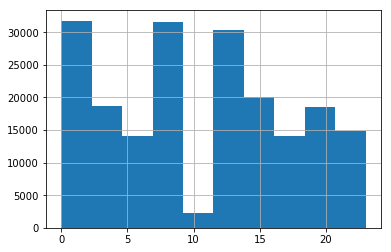

In [168]:
test_time['dt_hour'].hist()

In [169]:
test_time['dt_hour_4'] = 25
test_time.loc[(test_time['dt_hour'] >= 0) & (test_time['dt_hour'] < 4),'dt_hour_4'] = 0
test_time.loc[(test_time['dt_hour'] >= 4) & (test_time['dt_hour'] < 8),'dt_hour_4'] = 4
test_time.loc[(test_time['dt_hour'] >= 8) & (test_time['dt_hour'] < 12),'dt_hour_4'] = 8
test_time.loc[(test_time['dt_hour'] >= 12) & (test_time['dt_hour'] < 16),'dt_hour_4'] = 12
test_time.loc[(test_time['dt_hour'] >= 16) & (test_time['dt_hour'] < 20),'dt_hour_4'] = 16
test_time.loc[(test_time['dt_hour'] >= 20) & (test_time['dt_hour'] <= 24),'dt_hour_4'] = 20


# print(test_time['dt_hour_4'])
print(test_time.dt_hour_4.value_counts())

    

4     32946
8     32743
12    32623
20    32563
0     32556
16    32527
Name: dt_hour_4, dtype: int64


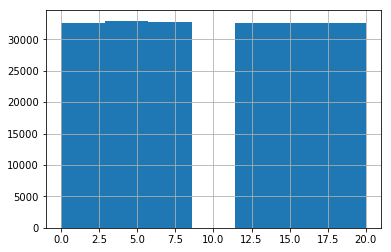

In [170]:
test_time.dt_hour_4.hist(bins=7)

Ok, so that seems to work properly. The apparent gap would appear to be due to the scale that Pandas is automatically trying to fit things onto. If there were a bit more flexibility in the Pandas histogram function we could change the axis length to 0 to 24 and it should come out with almost solid bars. 

In [171]:
test = test_time

In [172]:
test.dt_hour_4.head()

0     0
1     4
2     8
3    12
4    16
Name: dt_hour_4, dtype: int64

In [173]:
s = abs(test.sort_values(by=['station','linename','scp','date'])['entries'].diff())

In [174]:
s.value_counts().head()

0.0    31408
1.0     3360
2.0     2399
3.0     2021
4.0     1864
Name: entries, dtype: int64

In [175]:
s.std()

58405566.46180423

Ok, I am going to test different grouping and sorting techniques, put each one in a data set, and do some descripitive statistics on the resultling 'hourly' variable. The default for pandas sort is False.

In [176]:
#sort
test_sorted = s
test_sorted['hourly'] = abs(test.sort_values(by=['station','linename','scp','date','time'])['entries'].diff())

In [177]:
print(len(test_sorted))
print(len(test))

195959
195958


In [178]:
std_3 = test_sorted['hourly'].std()

In [179]:
print(std_3)

112116234.28921494


In [180]:
#create a new df in which we create the test id
test_id = test

In [181]:
test_id['id'] = test_id['station'] + test_id['linename'] + test_id['scp']

In [182]:
test_id['hourly'] = abs(test_id.sort_values(by=['id','date','time'])['entries'].diff())

In [183]:
std_4 = test_id['hourly'].std()

In [184]:
std_4/std_3

1.0004703115265954

Below I try to add the Kernel Density estimate to the histogram but the tails are just too fat and you get a flat density estimate. Useless.

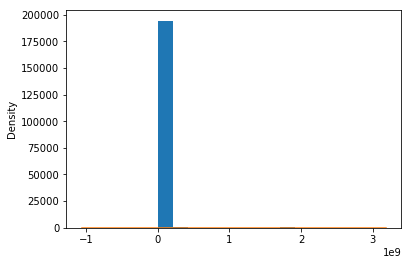

In [185]:
test_id['hourly'].hist()
test_id['hourly'].plot(kind='kde')

I am going to try to loop through the unique ids we made and calculate the differences within those id groups. Still can't get anything from the Kernel density estimate. 

In [186]:
len(test_id['id'].unique())

4571

In [187]:
# for i in test_id['id']:
#     print(i)

In [188]:
test_id.head()

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,dt_hour,dt_hour_4,id,hourly
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 00:00:00,REGULAR,6195217,2098317,0,0,59 STNQR456W02-00-00,5992912.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 04:00:00,REGULAR,6195240,2098318,4,4,59 STNQR456W02-00-00,23.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 08:00:00,REGULAR,6195256,2098347,8,8,59 STNQR456W02-00-00,16.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 12:00:00,REGULAR,6195346,2098432,12,12,59 STNQR456W02-00-00,90.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 16:00:00,REGULAR,6195518,2098491,16,16,59 STNQR456W02-00-00,172.0


### Older Plan

std_1 is the standard deviation from sorting by ['station','scp','date','time'] and taking the difference between entries. Nine digit standard deviations indicate a bad number. When we add 'linename' to the sorting terms we get a reduction in the standard deviation of about 81 million, so that is something.   

Next I take the absolute value of the difference to try to cancel out the noise of the units that count backwards. That doesn't really make much difference. But now we can look at dividing the standard deviations and seeing what that does and we see that the standard deviations improve by about half when we bring the 'linename' into the sort.  

Now I am going to try Jonathan's idea of creating a unique id by adding togehter the variables we think are important. Now the interesting thing is that the performance of the model seems to have actually gotten worse. The standard deviation of the model when we take the data sorted by the new id and then sorted by time is just a little over half the size of the original standard deviation. This is after taking the absolute value of the differences. So this is really terrible. The hourly entries are still coming out measured on a scale that reaches into the billions. This data is close to totally useless.  

There are going to be two sources of rediculous values, resets and different machines. To get any kind of reasonable estimates we have to get rid of the differences caused by different machines. We should make a list of the unique ids, loop through that list running diff on all the members in that list to populate 'hourly', and then go on to the next id in the list. Resets that happen within that group will still be a problem but those we might be able to deal with as missing data and just get rid of them. 

Joe says they just chose 20k as a cut-off and went from there. They found a kde plot that gave them a sort of reasonable argument for choosing that level as a cutoff. I am tempted to go with that.  

Now I need to review the commands for getting rid of data. I have to just throw out some data so that we can move on to other parts of the analysis. Once we get a reasonable analysis we can get a minimal acceptable product up and go back and make refinements if we like.  

So, the first thing is to go through the data set and have a criteria for making out things as NaN. A bit of an internet search is necessary.  



### New Plan
Talked to David and he expressed confidence that the whole problem could be handled by groupby. In particular, he said that all the trouble we went through with ids could be handled by `.groupby()` and `.diff()`.  

This is his **claim**: the diff funciton called on a group will return the values for the differences in the rows that are in that group, not the differences between the groups. I find this hard to believe, but he is the expert and I have to give it a try. 

The test data set still has the hourly and id variables attached but I don't see any need to get rid of them. I can keep them and create the new versions of hourly to compare, even.  

In [189]:
test_diff = test.groupby(['station','linename','scp'])['entries'].diff()

In [190]:
print(len(test_diff))
print(len(test))

195958
195958


In [191]:
test_diff.head()

0      NaN
1     23.0
2     16.0
3     90.0
4    172.0
Name: entries, dtype: float64

My God! I didn't believe him, but he is right. So now we have a diff for each of the entries of hourly and it seems like we should be able to just tack it back on the data set. I have to get the thing working now.  

First I will get the standard deviation and compare it to standard deviation 3, which was the best I had done so far. 

In [192]:
std_diff = test_diff.std()
print(std_diff)
print(std_diff/std_3)

11796568.896921124
0.10521731283348945


Ok, so this is a huget improvement, though you wouldn't know it from the absolute value of the standard deviation. That is about 1/20 the first standard deviation I had obtained.  

Lets look at a histogram. 

In [193]:
test_diff.describe()

count    1.913870e+05
mean     6.163596e+04
std      1.179657e+07
min     -1.821377e+09
25%      8.000000e+00
50%      6.700000e+01
75%      2.230000e+02
max      1.948041e+09
Name: entries, dtype: float64

In [194]:
6.163596e+04

61635.96

An average value of 61,000 is still insane but at least in the realm of human experience. 

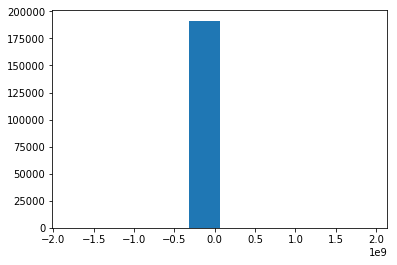

In [195]:
plt.hist(test_diff.dropna());

But the histogram is still on a scale of billions. That is rediculous. What can we do? What about sorting by date and time? What that done? The date time sort would have to be done after the groupby operation for it to have effect, no? 

In [196]:
test_diff_sorted = test.sort_values(['date','time'], ascending=True).groupby(['station','linename','scp'])['entries'].diff()

In [197]:
len(test_diff_sorted)

195958

In [198]:
test_diff_sorted.describe()

count    1.913870e+05
mean     9.999670e+03
std      1.058642e+08
min     -1.948056e+09
25%      6.000000e+00
50%      6.600000e+01
75%      2.330000e+02
max      1.948057e+09
Name: entries, dtype: float64

In [199]:
9.999670e+03

9999.67

In [200]:
test.head()

,unnamed: 0,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,dt_hour,dt_hour_4,id,hourly
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 00:00:00,REGULAR,6195217,2098317,0,0,59 STNQR456W02-00-00,5992912.0
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 04:00:00,REGULAR,6195240,2098318,4,4,59 STNQR456W02-00-00,23.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 08:00:00,REGULAR,6195256,2098347,8,8,59 STNQR456W02-00-00,16.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 12:00:00,REGULAR,6195346,2098432,12,12,59 STNQR456W02-00-00,90.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2017-05-27,2017-09-25 16:00:00,REGULAR,6195518,2098491,16,16,59 STNQR456W02-00-00,172.0


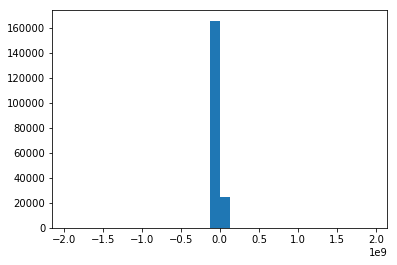

In [201]:
plt.hist(test_diff_sorted.dropna(), bins=30);

In [202]:
len(test.scp.unique())

230

Since there are more units than there are scps maybe we should throw them into the grouping mix, too. 

In [203]:
test_diff_sorted_units = test.sort_values(['date','time'], ascending=True).groupby(['station','linename','unit','scp'])['entries'].diff()

In [204]:
len(test_diff_sorted_units)
test_diff_sorted_units.describe()

count    1.912700e+05
mean     2.150756e+03
std      5.708554e+05
min     -4.470296e+06
25%      8.000000e+00
50%      6.700000e+01
75%      2.230000e+02
max      1.979471e+08
Name: entries, dtype: float64

In [205]:
2.150756e+03

2150.756

In [206]:
test_diff_sorted_units.isnull().value_counts()

False    191270
True       4688
Name: entries, dtype: int64

So this is the best the data set has ever been but I am still not sure that it is meaningful. What is this thing doing? 

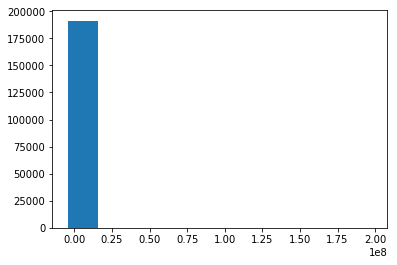

In [207]:
plt.hist(test_diff_sorted_units.dropna());

I have to find a way to get rid of the reset caused problems. I want to go through and assign the value of missing (nan) to any data point where the value is zero and the value preceeding it is greater than 10,000.  

Also, I want to compare the effects of sorting with units before scps or scps before units or leaving one or the other out.  

Finally, I want to think about my assumption that large values or large standard deviations are an infallible indicator of bad data.  

In [208]:
# testing = test.groupby(['station','linename','scp','unit'])apply(lambda x: \
#                                                              x.sort_values(['date','time'])).diff()

In [209]:
testing = test.groupby(['station','linename','scp','unit'])['entries'].diff()

In [210]:
testing

0           NaN
1          23.0
2          16.0
3          90.0
4         172.0
5         247.0
6         133.0
7          16.0
8          16.0
9          94.0
10        162.0
11        260.0
12        123.0
13         18.0
14         10.0
15         69.0
16        187.0
17        254.0
18        123.0
19          8.0
20         50.0
21        182.0
22        320.0
23        834.0
24        195.0
25         15.0
26         46.0
27        173.0
28        326.0
29        821.0
          ...  
195928      0.0
195929      0.0
195930      0.0
195931      0.0
195932      0.0
195933      0.0
195934      0.0
195935      0.0
195936      0.0
195937      0.0
195938      0.0
195939      0.0
195940      0.0
195941      0.0
195942      0.0
195943      0.0
195944      0.0
195945      0.0
195946      0.0
195947      0.0
195948      0.0
195949      0.0
195950      0.0
195951      0.0
195952      0.0
195953      0.0
195954      0.0
195955      0.0
195956      0.0
195957      0.0
Name: entries, Length: 1

In [211]:
testing2 = abs(testing)

In [212]:
testing2[testing2>3000] = np.nan

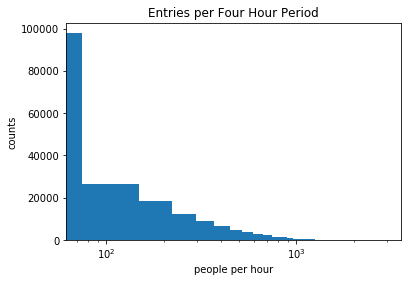

In [213]:
plt.xscale('log')
plt.hist(testing2.dropna(), bins=40)
plt.title("Entries per Four Hour Period")
plt.xlabel("people per hour")
plt.ylabel("counts")
plt.savefig("histogram");

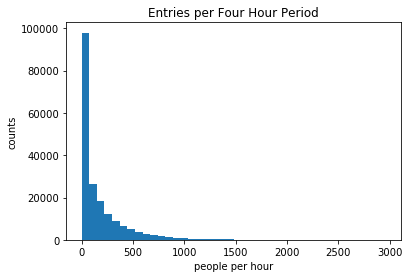

In [259]:
fig, ax = plt.subplots()

# plt.xscale('log')
plt.hist(testing2.dropna(), bins=40)
plt.title("Entries per Four Hour Period")
plt.xlabel("people per hour")
plt.ylabel("counts")
# plt.savefig("histogram")
fig.savefig('fig_entries.png', bbox_inches='tight');

In [215]:
print(testing2[testing2>2500])

4743      2630.0
46237     2822.0
151010    2608.0
151016    2776.0
151046    2769.0
151052    2622.0
151130    2854.0
151136    2564.0
151142    2678.0
152055    2523.0
152085    2861.0
152091    2965.0
152097    2769.0
157156    2697.0
157207    2729.0
175952    2508.0
Name: entries, dtype: float64


In [216]:
print(len(testing2))
print(len(test))

195958
195958


In [217]:
test['hourly'] = testing2

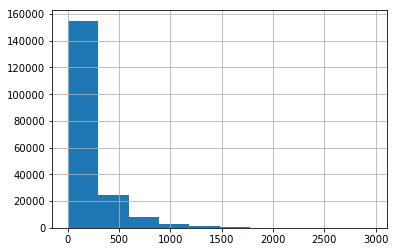

In [218]:
test['hourly'].dropna().hist()

In [219]:
highest_hourly = test.groupby('station')['hourly'].mean().sort_values(ascending=False)

In [220]:
x = list(x)
print(type(x))

<class 'list'>


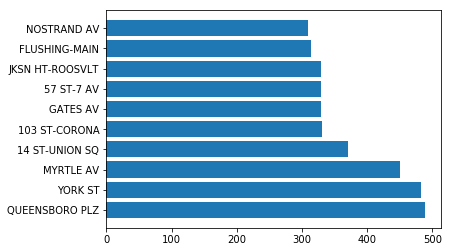

In [221]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

# x = list(highest_hourly.index[:5])
x = np.arange(10)
y = list(highest_hourly.values[:10])
y_ticks = list(highest_hourly.index[:10])
# print(y)


# formatter = FuncFormatter(millions)

fig, ax = plt.subplots()

# ax.yaxis.set_major_formatter(formatter)
plt.barh(x, y)
plt.yticks(x, y_ticks)
plt.savefig("top ten");

In [222]:
test['time'].value_counts().head()

2017-09-25 20:00:00    16872
2017-09-25 16:00:00    16868
2017-09-25 04:00:00    16863
2017-09-25 00:00:00    16862
2017-09-25 12:00:00    16851
Name: time, dtype: int64

In [223]:
print(test['time'].dtype)

datetime64[ns]


After our meeting with Zach we are thinking about doing a few more things. We need to do some kind of deal where we attempt to answer the client's question more directly. We have to get some kind of chart up that relates the percentage of women, income and foot traffic in one picture.  

Zach suggested making a scatter plot with cut-offs for the percentage of women and the percentage above the median income. That would give us a picture of two variables. I wonder if there is some way we could get three in there? We don't want just those two variables, we want three: women, money and foot traffic.  

Another thing I might do is combine the entry and exit data. Foot traffic is not just entries. In fact, people leaving might be more willing to talk than people entering.  

We should also concentrate on things that add value, i.e., that give us a new picture we can put up. Making pictures from the data we have rather than doing more cleaning might be better. 

In [224]:
#  plt.plot(x = test.dt_hour_4, y= test.hourly)
x = test.dt_hour_4
y = test.hourly

(array([  1.55018000e+05,   2.41990000e+04,   7.86400000e+03,
          2.53200000e+03,   9.92000000e+02,   4.00000000e+02,
          1.33000000e+02,   5.90000000e+01,   3.00000000e+01,
          1.00000000e+01]),
 array([    0. ,   296.5,   593. ,   889.5,  1186. ,  1482.5,  1779. ,
         2075.5,  2372. ,  2668.5,  2965. ]),
 <a list of 10 Patch objects>)

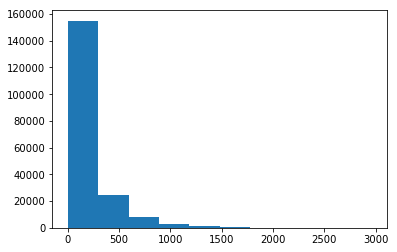

In [225]:
plt.hist(y.dropna())

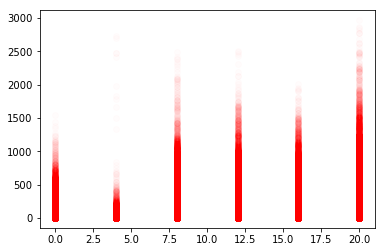

In [257]:
plt.scatter(x,y, c='r', alpha=0.01)
# plt.savefig('time_entry.jpg')
fig.savefig('time_entry_tight.png', bbox_inches='tight')

In [227]:
test.to_csv('test2.csv')

In [250]:
df2 = pd.DataFrame(y)

In [251]:
df2.columns=['hourly entries']

In [253]:
df2['time periods'] = pd.DataFrame(x)

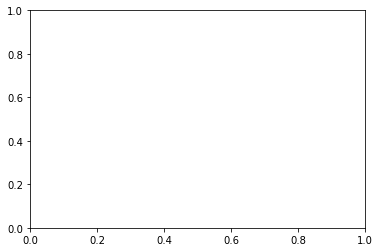

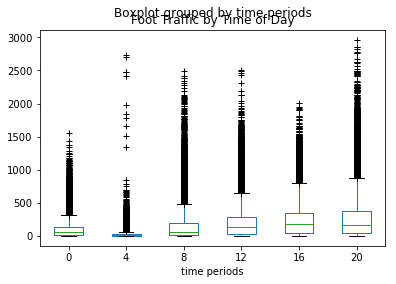

In [279]:

fig, ax = plt.subplots()

ax = df2.boxplot('hourly entries', by='time periods', grid = False, \
            notch=0, sym='+', vert=1, whis=1.5)

ax.set_title('Foot Traffic by Time of Day')
fig.savefig('boxplot_time.png', bbox_inches='tight')